# **PROJET DE BIG DATA**

![Employee Attrition Prediction by Analytics Vidya](https://images.squarespace-cdn.com/content/v1/5f1ef6d5ee0e7a1846b145d9/226b85ad-aa54-452f-9c3f-962dffb35606/website+images+%288%29.png)

## **Création d'une session Spark**

In [1]:
from pyspark.sql import SparkSession

# Create Spark Session (entry point for PySpark)
spark = SparkSession.builder \
    .appName("FitnessAndHealth") \
    .master("local[*]") \
    .getOrCreate()


# Create Spark Context
sc = spark.sparkContext

# Print Spark Context information
print("Spark Context Version:", sc.version)
print("Application Name:", sc.appName)

Spark Context Version: 3.5.4
Application Name: FitnessAndHealth


# **Création du DataFrame**

Nouus allons dans cette section importer notre dataset

In [2]:
df = spark.read.csv('health_fitness_dataset.csv',header=True,escape="\"")

Après importation du dataset, nous allons prévisualiser les 5 premières lignes de la base.

In [3]:
df.show(5,0)

+--------------+----------+---+------+---------+---------+---------------+----------------+---------+---------------+--------------+-----------+------------+-----------+---------------+----+------------------+-----------------------+------------------------+----------------+--------------+-------------+
|participant_id|date      |age|gender|height_cm|weight_kg|activity_type  |duration_minutes|intensity|calories_burned|avg_heart_rate|hours_sleep|stress_level|daily_steps|hydration_level|bmi |resting_heart_rate|blood_pressure_systolic|blood_pressure_diastolic|health_condition|smoking_status|fitness_level|
+--------------+----------+---+------+---------+---------+---------------+----------------+---------+---------------+--------------+-----------+------------+-----------+---------------+----+------------------+-----------------------+------------------------+----------------+--------------+-------------+
|1             |2024-01-01|56 |F     |165.3    |53.7     |Dancing        |41         

# **Analyse exploratoire des données**
Maintenant que nous avons vu les variables présentes dans cet ensemble de données, effectuons une analyse exploratoire des données pour mieux comprendre ces points de données :

1. Commençons par compter le nombre de lignes dans le DataFram :

In [4]:
df.count()

687701

Il en ressort que ce dataset contient 687701 obseravations.

2. Vérifions le type de notre base de données

In [5]:
type(df)

pyspark.sql.dataframe.DataFrame

3. Vérifions le nombres de participants

In [ ]:
df.select('participant_id').distinct().count()

3000

Il y a au total 3000 participants dans notre base de données

4. Nombre de jours de suivi par participant

In [7]:
from pyspark.sql.functions import countDistinct

# Count the number of days each participant was followed
days_per_participant = df.groupBy("participant_id").agg(countDistinct("date").alias("days_followed"))

# Show the results
days_per_participant.show()


+--------------+-------------+
|participant_id|days_followed|
+--------------+-------------+
|           296|          238|
|           467|          232|
|           691|          246|
|           829|          235|
|          1090|          232|
|          1436|          240|
|          1512|          222|
|          1572|          226|
|           675|          229|
|          1159|          236|
|          2069|          231|
|          2088|          224|
|          2136|          240|
|          2162|          243|
|          2294|          226|
|          2904|          234|
|           853|          235|
|           944|          223|
|          1372|          228|
|          1394|          212|
+--------------+-------------+
only showing top 20 rows



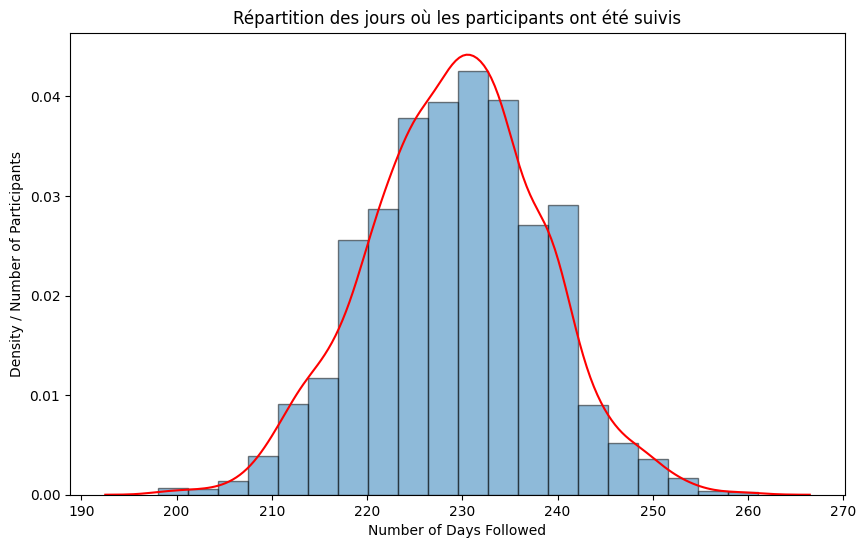

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
days_per_participant_pd = days_per_participant.toPandas()

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(days_per_participant_pd['days_followed'], bins=20, edgecolor='black', density=True, alpha=0.5) #Set density=True for density plot

# Add the density curve using seaborn
sns.kdeplot(days_per_participant_pd['days_followed'], color='red')


plt.xlabel('Number of Days Followed')
plt.ylabel('Density / Number of Participants') #Change y label to density
plt.title('Répartition des jours où les participants ont été suivis')
plt.show()


# **Détection des valeurs manquantes**

In [ ]:
from pyspark.sql.functions import col,isnan, when, count

# Count missing values per column
missing_values_df = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])

# Show the result
missing_values_df.show()


+--------------+----+---+------+---------+---------+-------------+----------------+---------+---------------+--------------+-----------+------------+-----------+---------------+---+------------------+-----------------------+------------------------+----------------+--------------+-------------+
|participant_id|date|age|gender|height_cm|weight_kg|activity_type|duration_minutes|intensity|calories_burned|avg_heart_rate|hours_sleep|stress_level|daily_steps|hydration_level|bmi|resting_heart_rate|blood_pressure_systolic|blood_pressure_diastolic|health_condition|smoking_status|fitness_level|
+--------------+----+---+------+---------+---------+-------------+----------------+---------+---------------+--------------+-----------+------------+-----------+---------------+---+------------------+-----------------------+------------------------+----------------+--------------+-------------+
|             0|   0|  0|     0|        0|        0|            0|               0|        0|              0|   

On voit qu'il n'y a pas de valeurs manquantes dans la base.

# **Detection des doublouns**

In [ ]:
from pyspark.sql.functions import count

# Group by all columns and count occurrences
duplicate_counts = df.groupBy(*df.columns).count()

# Filter out rows where the count is greater than 1 (duplicates)
duplicates = duplicate_counts.filter("count > 1")

# Show the duplicates
duplicates.show()

# You can also get the number of duplicate rows
num_duplicates = duplicates.count()
print(f"Number of duplicate rows: {num_duplicates}")


+--------------+----+---+------+---------+---------+-------------+----------------+---------+---------------+--------------+-----------+------------+-----------+---------------+---+------------------+-----------------------+------------------------+----------------+--------------+-------------+-----+
|participant_id|date|age|gender|height_cm|weight_kg|activity_type|duration_minutes|intensity|calories_burned|avg_heart_rate|hours_sleep|stress_level|daily_steps|hydration_level|bmi|resting_heart_rate|blood_pressure_systolic|blood_pressure_diastolic|health_condition|smoking_status|fitness_level|count|
+--------------+----+---+------+---------+---------+-------------+----------------+---------+---------------+--------------+-----------+------------+-----------+---------------+---+------------------+-----------------------+------------------------+----------------+--------------+-------------+-----+
+--------------+----+---+------+---------+---------+-------------+----------------+---------+-

# **Indicateur 1** : Nombre et pourcentage des participants par sexe

In [12]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, round  # Import the 'round' function

# Get the 3000 participant IDs with their genders
participants_gender = df.select("participant_id", "gender").distinct()

# Count participants by gender
gender_counts = participants_gender.groupBy("gender").agg(count("*").alias("count"))

# Calculate the percentage of participants by gender
total_participants = participants_gender.count()
gender_percentages = gender_counts.withColumn("percentage", round((col("count") / total_participants) * 100, 2))
gender_percentages.show()

+------+-----+----------+
|gender|count|percentage|
+------+-----+----------+
|     F| 1480|     49.33|
|     M| 1456|     48.53|
| Other|   64|      2.13|
+------+-----+----------+



# **Représentation graphique de l'indicateur 1**

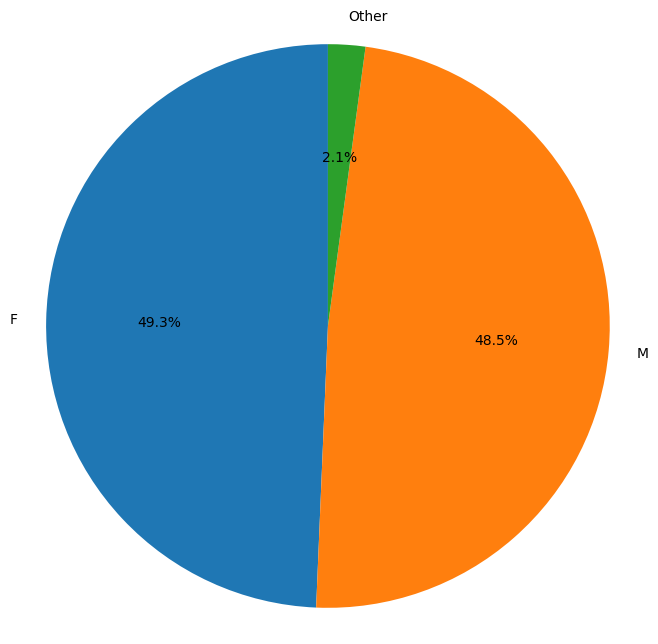

In [13]:
# Convert to Pandas DataFrame for plotting
gender_percentages_pd = gender_percentages.toPandas()


# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(gender_percentages_pd["count"], labels=gender_percentages_pd["gender"], autopct='%1.1f%%', startangle=90)
#plt.title("Répartition des participants par sexe")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


# **Indicateur 2:** Groupement des participants par tranche d’âge (e.g., 18-25, 26-35, etc.) et comptage.

In [14]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import when, lit

# Define age ranges and corresponding labels
age_ranges = [
    (18, 25, "18-25"),
    (26, 35, "26-35"),
    (36, 45, "36-45"),
    (46, 55, "46-55"),
    (56, 65, "56-65"),
    ]

# Create a new column 'age_group' based on the defined age ranges
age_group_expr = None
for min_age, max_age, label in age_ranges:
  if age_group_expr is None:
    age_group_expr = when((df["age"] >= min_age) & (df["age"] <= max_age), lit(label))
  else:
    age_group_expr = age_group_expr.when((df["age"] >= min_age) & (df["age"] <= max_age), lit(label))

# Handle participants outside the defined age ranges (assign them to "other")
age_group_expr = age_group_expr.otherwise("Other")

df = df.withColumn("age_group", age_group_expr)

# Group by age group and count participants
age_group_counts = df.groupBy("age_group").agg(countDistinct("participant_id").alias("participant_count"))

# Show the results
age_group_counts.show()




+---------+-----------------+
|age_group|participant_count|
+---------+-----------------+
|    18-25|              492|
|    26-35|              600|
|    46-55|              641|
|    36-45|              646|
|    56-65|              621|
+---------+-----------------+



**Représentation graphique**

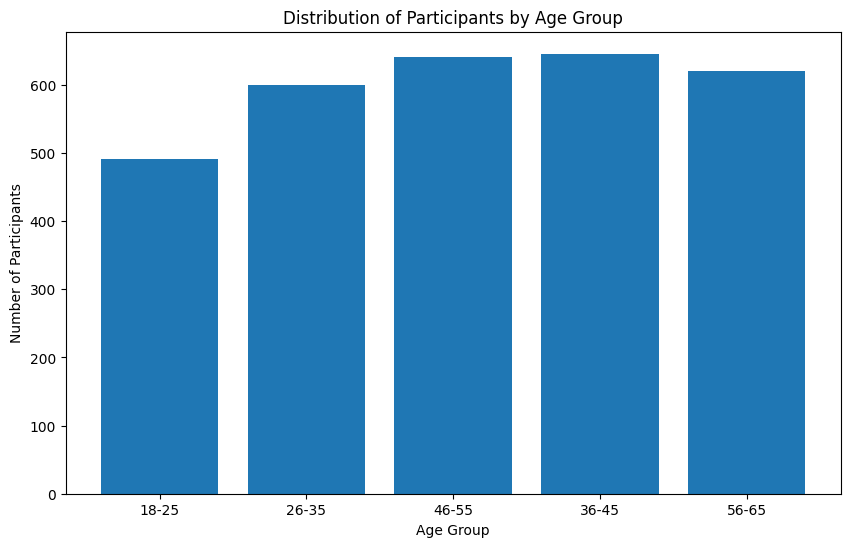

In [15]:
# Convert to Pandas DataFrame for plotting (optional)
age_group_counts_pd = age_group_counts.toPandas()

# Create a bar chart (optional)
plt.figure(figsize=(10, 6))
plt.bar(age_group_counts_pd["age_group"], age_group_counts_pd["participant_count"])
plt.xlabel("Age Group")
plt.ylabel("Number of Participants")
plt.title("Distribution of Participants by Age Group")
plt.show()

# **Indicateur 3 :** Analyse du BMI moyen pour chaque tranche d’âge afin de détecter des tendances dans la population

In [16]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg, round

# Calculate the average BMI for each age group
bmi_by_age_group = df.groupBy("age_group").agg(round(avg("bmi"), 2).alias("average_bmi"))

# Show the results
bmi_by_age_group.show()


+---------+-----------+
|age_group|average_bmi|
+---------+-----------+
|    18-25|      22.54|
|    26-35|      22.52|
|    46-55|      22.95|
|    36-45|      22.66|
|    56-65|      22.94|
+---------+-----------+



# Graphique

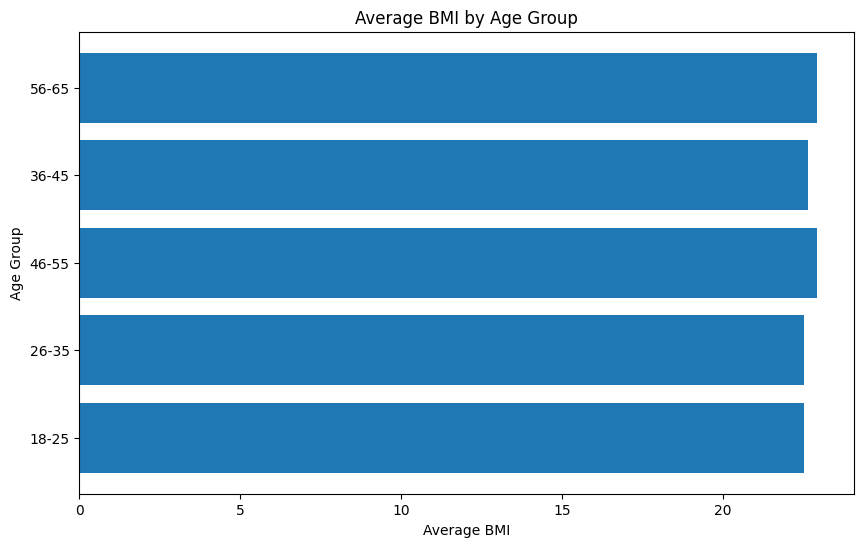

In [17]:
# Convert to Pandas DataFrame for plotting
bmi_by_age_group_pd = bmi_by_age_group.toPandas()

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(bmi_by_age_group_pd["age_group"], bmi_by_age_group_pd["average_bmi"])
plt.xlabel("Average BMI")
plt.ylabel("Age Group")
plt.title("Average BMI by Age Group")
plt.show()

# **Indicateur 4:**  la durée moyenne (duration_minutes) pour chaque type d’activité (activity_type)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average duration for each activity type
average_duration_by_activity = df.groupBy("activity_type").agg(round(avg("duration_minutes"), 2).alias("average_duration"))

average_duration_by_activity.show()

+---------------+----------------+
|  activity_type|average_duration|
+---------------+----------------+
|         Tennis|           70.01|
|        Walking|           69.89|
|       Swimming|           70.07|
|     Basketball|           70.14|
|           Yoga|           69.78|
|Weight Training|           70.02|
|        Running|           70.05|
|           HIIT|           69.83|
|        Cycling|            70.1|
|        Dancing|           70.24|
+---------------+----------------+



# **Représentation graphique**

<ipython-input-20-9eab2ea34916>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="activity_type", y="average_duration", data=average_duration_by_activity_pd, palette="viridis")


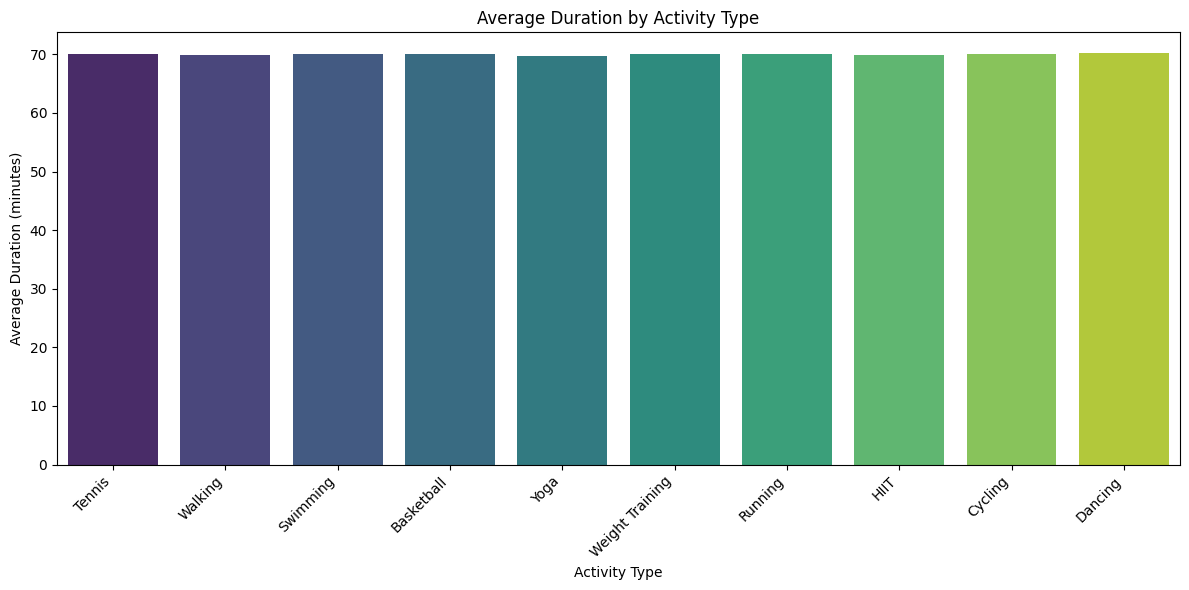

In [20]:
# Convert to Pandas DataFrame for plotting with seaborn
average_duration_by_activity_pd = average_duration_by_activity.toPandas()

# Create a bar plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="activity_type", y="average_duration", data=average_duration_by_activity_pd, palette="viridis")
plt.xlabel("Activity Type")
plt.ylabel("Average Duration (minutes)")
plt.title("Average Duration by Activity Type")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


# **Indicateur 5 :** Moyenne et somme des calories brûlées pour chaque activité.

In [27]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum, avg, col #Import col

# Calculate the average and sum of calories burned for each activity
calories_by_activity = df.groupBy("activity_type").agg(
    round(avg("calories_burned"), 2).alias("average_calories_burned"),
    round(sum(col("calories_burned").cast("double")), 2).alias("total_calories_burned") # Cast to double/float
)

calories_by_activity.show()

+---------------+-----------------------+---------------------+
|  activity_type|average_calories_burned|total_calories_burned|
+---------------+-----------------------+---------------------+
|         Tennis|                  15.85|            1086012.6|
|        Walking|                   8.23|             560239.2|
|       Swimming|                  15.19|            1033281.2|
|     Basketball|                  17.36|            1189637.9|
|           Yoga|                   6.51|             455190.8|
|Weight Training|                  13.04|             908412.1|
|        Running|                  21.33|            1432049.2|
|           HIIT|                  25.99|            1803364.4|
|        Cycling|                   18.5|            1279867.2|
|        Dancing|                  11.99|             829682.3|
+---------------+-----------------------+---------------------+



# **Representation graphique**

<ipython-input-28-87d29f64c53a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="activity_type", y="total_calories_burned", data=calories_by_activity_pd, palette="viridis")


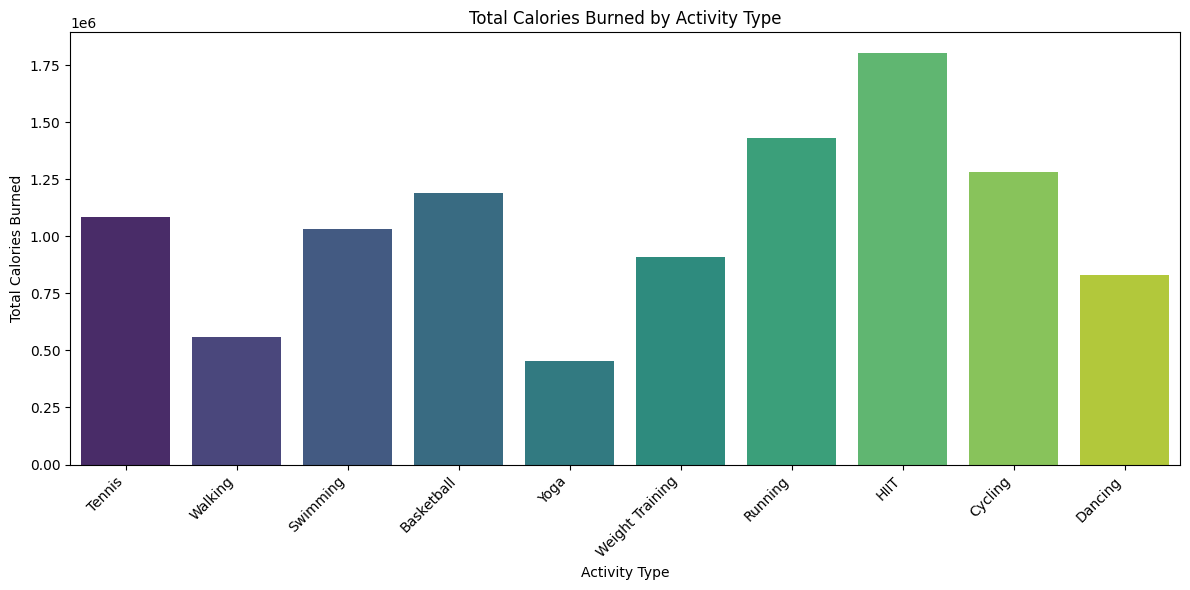

In [28]:
# Convert to Pandas DataFrame for plotting
calories_by_activity_pd = calories_by_activity.toPandas()

# Create a bar chart for the total calories burned by activity type
plt.figure(figsize=(12, 6))
sns.barplot(x="activity_type", y="total_calories_burned", data=calories_by_activity_pd, palette="viridis")
plt.xlabel("Activity Type")
plt.ylabel("Total Calories Burned")
plt.title("Total Calories Burned by Activity Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# **Indicateur 6 :** Répartition des participants selon l’intensité de leurs exercices (low, medium, high)

+---------+-----------------+
|intensity|participant_count|
+---------+-----------------+
|     High|             3000|
|      Low|             3000|
|   Medium|             3000|
+---------+-----------------+



<ipython-input-87-5032b3d162a9>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="intensity", y="participant_count", data=intensity_distribution_pd, palette="Blues_d")


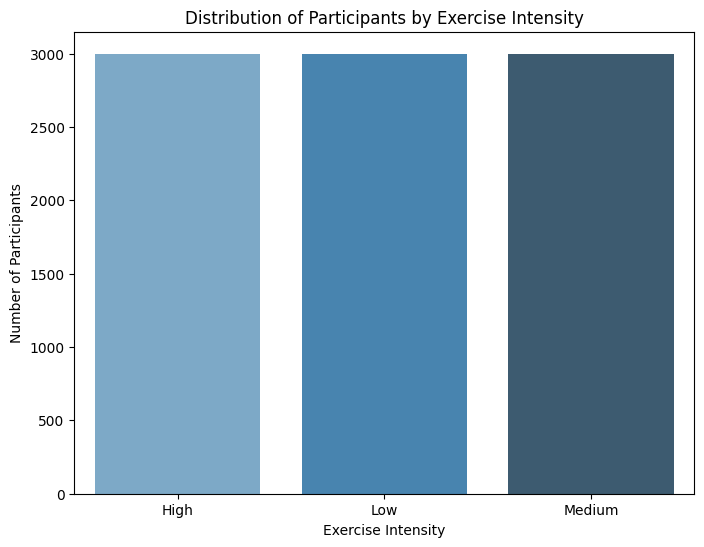

In [ ]:
import matplotlib.pyplot as plt
# Calculate the distribution of participants by exercise intensity
intensity_distribution = df.groupBy("intensity").agg(countDistinct("participant_id").alias("participant_count"))

# Show the results
intensity_distribution.show()

# Visualization (optional)
# Convert to Pandas DataFrame for plotting
intensity_distribution_pd = intensity_distribution.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="intensity", y="participant_count", data=intensity_distribution_pd, palette="Blues_d")
plt.xlabel("Exercise Intensity")
plt.ylabel("Number of Participants")
plt.title("Distribution of Participants by Exercise Intensity")
plt.show()


## **Indicateur 7** : Fréquence cardiaque moyenne (avg_heart_rate) pour chaque niveau d’intensité

+---------+------------------+
|intensity|average_heart_rate|
+---------+------------------+
|     High|            151.08|
|      Low|            115.43|
|   Medium|            133.26|
+---------+------------------+



<ipython-input-93-cb4de8ccf463>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="intensity", y="average_heart_rate", data=average_heart_rate_by_intensity_pd, palette="Greens_d")


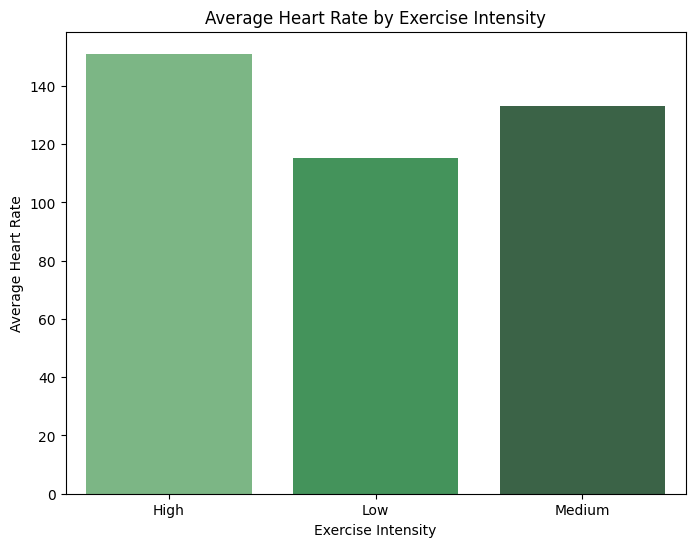

In [ ]:
import matplotlib.pyplot as plt
# Calculate the average heart rate for each intensity level
average_heart_rate_by_intensity = df.groupBy("intensity").agg(round(avg("avg_heart_rate"), 2).alias("average_heart_rate"))

# Show the results
average_heart_rate_by_intensity.show()

# Visualization (optional)
# Convert to Pandas DataFrame for plotting
average_heart_rate_by_intensity_pd = average_heart_rate_by_intensity.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="intensity", y="average_heart_rate", data=average_heart_rate_by_intensity_pd, palette="Greens_d")
plt.xlabel("Exercise Intensity")
plt.ylabel("Average Heart Rate")
plt.title("Average Heart Rate by Exercise Intensity")
plt.show()


# **Indicateur 8** : Comparons les fréquences cardiaques, les niveaux de stress et d’autres métriques entre les groupes “jamais”, “ancien” et “actuel” fumeurs


+--------------+------------------+--------------------+------------------+-----------------------+
|smoking_status|average_heart_rate|average_stress_level|       average_bmi|average_calories_burned|
+--------------+------------------+--------------------+------------------+-----------------------+
|        Former|131.58530108768306|   5.256778270644711|  33.3529458589054|     15.331317372546781|
|         Never|131.43804702495203|   5.253985124760077| 33.27558248560398|     15.390106285988736|
|       Current|131.31438620910177|   5.239337540322201|33.246729834196906|     15.424153821557184|
+--------------+------------------+--------------------+------------------+-----------------------+



<ipython-input-101-c1ec73e1ee43>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="smoking_status", y=metric, data=smoker_metrics_pd, palette="Set2") # Change x to "smoking_status"


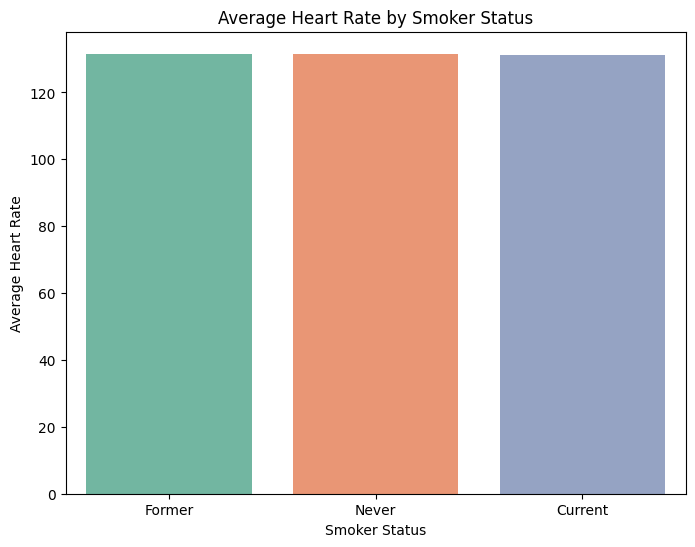

<ipython-input-101-c1ec73e1ee43>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="smoking_status", y=metric, data=smoker_metrics_pd, palette="Set2") # Change x to "smoking_status"


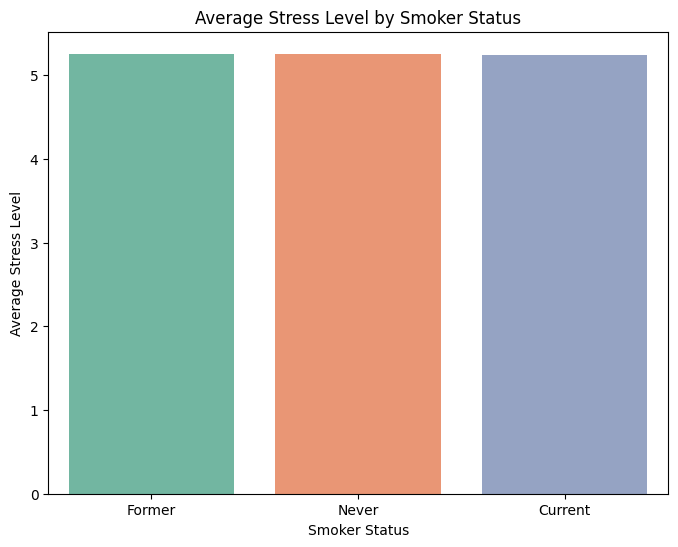

<ipython-input-101-c1ec73e1ee43>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="smoking_status", y=metric, data=smoker_metrics_pd, palette="Set2") # Change x to "smoking_status"


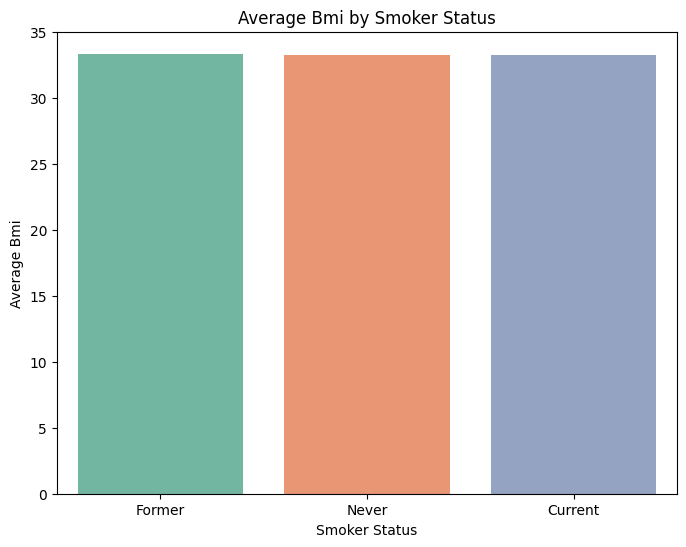

<ipython-input-101-c1ec73e1ee43>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="smoking_status", y=metric, data=smoker_metrics_pd, palette="Set2") # Change x to "smoking_status"


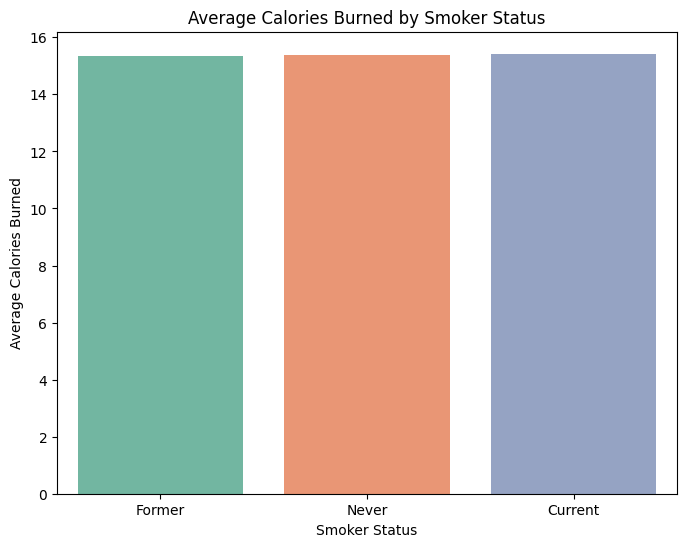

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for plotting

# Group data by smoking status and calculate average heart rate, stress level, etc.
# Change "smoker" to "smoking_status" to match the actual column name
smoker_metrics = df.groupBy("smoking_status").agg(
    avg("avg_heart_rate").alias("average_heart_rate"),
    avg("stress_level").alias("average_stress_level"),
    avg("bmi").alias("average_bmi"),
    avg("calories_burned").alias("average_calories_burned")
    # Add other metrics as needed
)

# Show the results
smoker_metrics.show()

# Visualization (optional)
# Convert to Pandas DataFrame for plotting
smoker_metrics_pd = smoker_metrics.toPandas()

# Create bar plots for each metric
metrics = ["average_heart_rate", "average_stress_level", "average_bmi", "average_calories_burned"]
for metric in metrics:
    plt.figure(figsize=(8, 6))
    sns.barplot(x="smoking_status", y=metric, data=smoker_metrics_pd, palette="Set2") # Change x to "smoking_status"
    plt.xlabel("Smoker Status")
    plt.ylabel(metric.replace("_", " ").title())
    plt.title(f"{metric.replace('_', ' ').title()} by Smoker Status")
    plt.show()

# **Indicateur 9** : Répartition des participants ayant ou non des problèmes de santé (health_condition)

+----------------+-----------------+
|health_condition|participant_count|
+----------------+-----------------+
|            None|             2138|
|        Diabetes|              283|
|    Hypertension|              434|
|          Asthma|              145|
+----------------+-----------------+



<ipython-input-25-048eaf3d5415>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="health_condition", y="participant_count", data=health_condition_distribution_pd, palette="Set3")


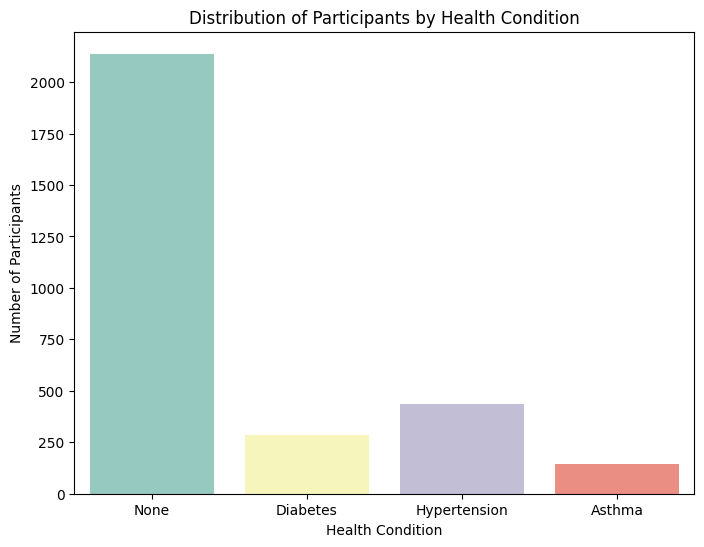

In [25]:
import matplotlib.pyplot as plt
# Calculate the distribution of participants with and without health conditions
health_condition_distribution = df.groupBy("health_condition").agg(countDistinct("participant_id").alias("participant_count"))

# Show the results
health_condition_distribution.show()

# Visualization (optional)
# Convert to Pandas DataFrame for plotting
health_condition_distribution_pd = health_condition_distribution.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="health_condition", y="participant_count", data=health_condition_distribution_pd, palette="Set3")
plt.xlabel("Health Condition")
plt.ylabel("Number of Participants")
plt.title("Distribution of Participants by Health Condition")
plt.show()


# **Indicateur 10** : Moyenne du niveau de stress (stress_level) pour chaque type et intensité d’activité

+---------------+---------+--------------------+
|  activity_type|intensity|average_stress_level|
+---------------+---------+--------------------+
|        Dancing|     High|                5.25|
|         Tennis|   Medium|                5.26|
|           HIIT|     High|                5.25|
|           Yoga|   Medium|                5.25|
|        Cycling|      Low|                5.25|
|         Tennis|     High|                5.28|
|        Cycling|     High|                5.24|
|         Tennis|      Low|                5.28|
|     Basketball|   Medium|                5.22|
|        Dancing|      Low|                5.28|
|     Basketball|     High|                5.25|
|           Yoga|      Low|                5.24|
|Weight Training|      Low|                5.25|
|           HIIT|   Medium|                5.24|
|           HIIT|      Low|                5.28|
|Weight Training|     High|                5.25|
|        Running|     High|                5.25|
|        Running|   

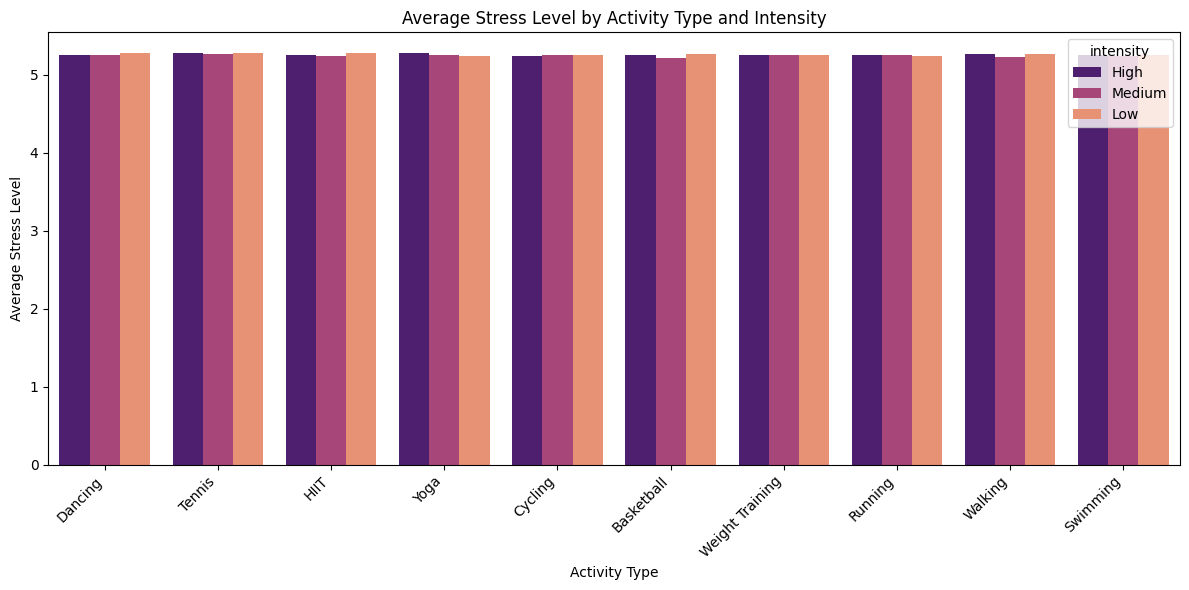

In [ ]:
import matplotlib.pyplot as plt
# Calculate the average stress level for each activity type and intensity
stress_by_activity_intensity = df.groupBy("activity_type", "intensity").agg(
    round(avg("stress_level"), 2).alias("average_stress_level")
)

# Show the results
stress_by_activity_intensity.show()

# Visualization (optional)
# Convert to Pandas DataFrame for plotting
stress_by_activity_intensity_pd = stress_by_activity_intensity.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="activity_type", y="average_stress_level", hue="intensity", data=stress_by_activity_intensity_pd, palette="magma")
plt.xlabel("Activity Type")
plt.ylabel("Average Stress Level")
plt.title("Average Stress Level by Activity Type and Intensity")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
